# 1- Packages

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats
from textwrap import wrap

%matplotlib inline

# 2 - Data acquisition

In [4]:
Europe=pd.read_excel(r'C:\Users\Eric.Li\Documents\IPO data\IPO.xlsx',sheet_name="Europe").set_index("Ticker")
price_Europe=pd.read_excel(r'C:\Users\Eric.Li\Documents\IPO data\IPO.xlsx',sheet_name="Europe last").set_index("Ticker")
high_Europe=pd.read_excel(r'C:\Users\Eric.Li\Documents\IPO data\IPO.xlsx',sheet_name="Europe high").set_index("Ticker")
index_Europe=pd.read_excel(r'C:\Users\Eric.Li\Documents\IPO data\IPO.xlsx',sheet_name="Europe index").set_index("Ticker")
date_Europe=pd.read_excel(r'C:\Users\Eric.Li\Documents\IPO data\IPO.xlsx',sheet_name="Europe date").set_index("Ticker")

In [5]:
NA=pd.read_excel(r'C:\Users\Eric.Li\Documents\IPO data\IPO.xlsx',sheet_name="NA").set_index("Ticker")
price_NA=pd.read_excel(r'C:\Users\Eric.Li\Documents\IPO data\IPO.xlsx',sheet_name="NA last").set_index("Ticker")
high_NA=pd.read_excel(r'C:\Users\Eric.Li\Documents\IPO data\IPO.xlsx',sheet_name="NA high").set_index("Ticker")
index_NA=pd.read_excel(r'C:\Users\Eric.Li\Documents\IPO data\IPO.xlsx',sheet_name="NA index").set_index("Ticker")
date_NA=pd.read_excel(r'C:\Users\Eric.Li\Documents\IPO data\IPO.xlsx',sheet_name="NA date").set_index("Ticker")

In [6]:
Asia=pd.read_excel(r'C:\Users\Eric.Li\Documents\IPO data\IPO.xlsx',sheet_name="Asia").set_index("Ticker")
price_Asia=pd.read_excel(r'C:\Users\Eric.Li\Documents\IPO data\IPO.xlsx',sheet_name="Asia last").set_index("Ticker")
high_Asia=pd.read_excel(r'C:\Users\Eric.Li\Documents\IPO data\IPO.xlsx',sheet_name="Asia high").set_index("Ticker")
index_Asia=pd.read_excel(r'C:\Users\Eric.Li\Documents\IPO data\IPO.xlsx',sheet_name="Asia index").set_index("Ticker")
date_Asia=pd.read_excel(r'C:\Users\Eric.Li\Documents\IPO data\IPO.xlsx',sheet_name="Asia date").set_index("Ticker")

In [895]:
Global=Europe.append(NA).append(Asia)

In [638]:
def get_return(price_df,index_df):
    abs_return=price_df.diff(1,axis=1)/price_df.shift(1,axis=1)
    index_return=index_df.diff(1,axis=1)/index_df.shift(1,axis=1)
    rel_return=abs_return-index_return
    rel_return_half=abs_return-0.5*index_return
    return abs_return,rel_return,rel_return_half

In [639]:
abs_return_Europe,rel_return_Europe,rel_return_half_Europe=get_return(price_Europe,index_Europe)
abs_return_NA,rel_return_NA,rel_return_half_NA=get_return(price_NA,index_NA)
abs_return_Asia,rel_return_Asia,rel_return_half_Asia=get_return(price_Asia,index_Asia)

In [274]:
price_index=pd.read_excel(r'C:\Users\Eric.Li\Documents\IPO data\IPO.xlsx',sheet_name="Index").set_index("Ticker")
abs_return_index=price_index.diff(1,axis=1)/price_index.shift(1,axis=1)

# 3 - Strategy by day

In [248]:
def trading_analytics(signal_df):
    ind_return=((1+signal_df).cumprod()-1).ffill().iloc[-1]
    win=ind_return[ind_return>0]
    lose=ind_return[ind_return<0]
    count=ind_return.shape[0]
    hit_rate=win.shape[0]/count*1.0
    payoff=-win.mean()/lose.mean()*1.0
    avg_return=ind_return.mean()
    holding=signal_df.count(axis=0).mean()
    return count, hit_rate,payoff,avg_return,holding       

In [700]:
def IPO_long(data_df,price_df,high_df,return_df,Size,Open,Close,liquidity_constraint,start_day,end_day,holding,roll_range):
    close_high_evaluate=(price_df.expanding(min_periods=start_day,axis=1).max()==price_df).iloc[:,start_day-1:end_day]
    
    if high_df is None:
        high_evaluate=close_high_evaluate
    else:
        intraday_high_evaluate=(high_df.expanding(min_periods=start_day,axis=1).max()==high_df).iloc[:,start_day-1:end_day]
        high_evaluate=close_high_evaluate & intraday_hi gh_evaluate
    
    high_evaluate=high_evaluate[high_evaluate==True].dropna(how='all',axis=0)
       
    target_data=data_df[(data_df["Market_cap"]>=Size)&(data_df["Offer_Day1_Open"]>Open)&(data_df["Offer_Day1_Close"]>Close)&(data_df["5d_liquidity"]>liquidity_constraint)]
    trade_day=high_evaluate.apply(lambda x:x.tolist().index(1.0),axis=1).reindex(target_data.index.tolist()).dropna()    
    end_range=trade_day.to_frame().apply(lambda x:get_range(x.name,int(x),price_df,holding),axis=1)
    
    target_return=return_df.loc[trade_day.index]
    signal_df=target_return.apply(lambda x:x[start_day+int(trade_day[x.name]):start_day+int(trade_day[x.name])+holding*2] if end_range[x.name]>roll_range\
                                  else x[start_day+int(trade_day[x.name]):start_day+int(trade_day[x.name])+holding],axis=1)# no need to shift as slicing takes idex from 0
    signal_df["Index"]=signal_df.apply(lambda x:(x.name,data_df["IPO_date"].loc[x.name],int(trade_day[x.name]+start_day+1)),axis=1)# plus 1 as the start date is one after the new high
    signal_df=signal_df.set_index("Index")
    return signal_df.T

In [915]:
def signal_simple_stop(signal_df,stop_level):
    signal_cum_move=((1+signal_df).cumprod()-1)
    signal_df_stop=signal_df[-(signal_cum_move.expanding().min().shift(1,axis=0)<-stop_level)]
    return signal_df_stop

In [250]:
def signal_normal_stop(signal_df,return_df,stop_level):
    vol_column=signal_df.apply(lambda x: return_df.loc[x.name[0]].iloc[:x.name[2]].std(),axis=0)
    signal_cum_nmove=((1+signal_df).cumprod()-1)/vol_column
    signal_df_stop=signal_df[-(signal_cum_nmove.expanding().min().shift(1,axis=0)<-stop_level)]
    return signal_df_stop

In [251]:
def signal_move_stop(signal_df,return_df,stop_level):
    vol_column=signal_df.apply(lambda x: return_df.loc[x.name[0]].iloc[:x.name[2]].std(),axis=0)
    signal_nmove=signal_df/vol_column
    signal_df_stop=signal_df[-(signal_nmove.expanding().min().shift(1,axis=0)<-stop_level)]
    return signal_df_stop

In [590]:
def get_range(ticker,entry,price_df,holding):
    end_price=price_df.loc[ticker].iloc[entry+holding]
    high_price=price_df.loc[ticker].iloc[:entry+holding+1].max()
    low_price=price_df.loc[ticker].iloc[:entry+holding+1].min()
    range_price=(end_price-low_price)/(high_price-low_price)
    return range_price

In [491]:
def get_range_from_df(signal_df,price_df):
    end_price=signal_df.apply(lambda x: price_df.loc[x.name[0]].iloc[x.name[2]+40],axis=0)
    high_price=signal_df.apply(lambda x: price_df.loc[x.name[0]].iloc[:x.name[2]+40+1].max(),axis=0)
    low_price=signal_df.apply(lambda x: price_df.loc[x.name[0]].iloc[:x.name[2]+40+1].min(),axis=0)
    range_price=(end_price-low_price)/(high_price-low_price)
    return range_price

In [790]:
#signal_Europe_abs=IPO_long(Europe,price_Europe,None,abs_return_Europe,500,-2,-2,3,10,40,40,0.99)
signal_NA_abs=IPO_long(NA,price_NA,None,abs_return_NA,500,-2,-2,3,10,40,40,0.99)
#signal_Asia_abs=IPO_long(Asia,price_Asia,None,abs_return_Asia,500,-2,-2,3,10,50,40,0.99)

In [791]:
trading_analytics(signal_NA_abs)

(407,
 0.5896805896805897,
 1.5250681038617846,
 0.057722547572390266,
 45.20884520884521)

In [684]:
## Build the abs signal
signal_Europe_abs=IPO_long(Europe,price_Europe,None,abs_return_Europe,500,-2,-2,3,5,100,40,0.99)
signal_NA_abs=IPO_long(NA,price_NA,None,abs_return_NA,500,-2,-2,3,5,100,40,0.99)
signal_Asia_abs=IPO_long(Asia,price_Asia,None,abs_return_Asia,500,-2,-2,3,5,100,40,0.99)

In [645]:
## Build the rel signal
signal_Europe_rel=IPO_long(Europe,price_Europe,None,rel_return_Europe,500,-2,-2,3,5,100,40,0.99)
signal_NA_rel=IPO_long(NA,price_NA,None,rel_return_NA,500,-2,-2,3,5,100,40,0.99)
signal_Asia_rel=IPO_long(Asia,price_Asia,None,rel_return_Asia,500,-2,-2,3,5,100,40,0.99)

In [646]:
## Build the half rel signal
signal_Europe_half_rel=IPO_long(Europe,price_Europe,None,rel_return_half_Europe,500,-2,-2,3,5,100,40,0.99)
signal_NA_half_rel=IPO_long(NA,price_NA,None,rel_return_half_NA,500,-2,-2,3,5,100,40,0.99)
signal_Asia_half_rel=IPO_long(Asia,price_Asia,None,rel_return_half_Asia,500,-2,-2,3,5,100,40,0.99)

In [424]:
## Build the signal with intraday high
signal_Europe_intraday=IPO_long(Europe,price_Europe,high_Europe,abs_return_Europe,500,-2,-2,0,3,5,100,40)
signal_NA_intraday=IPO_long(NA,price_NA,high_NA,abs_return_NA,500,-2,-2,0,3,5,100,40)
signal_Asia_intraday=IPO_long(Asia,price_Asia,high_Asia,abs_return_Asia,500,-2,-2,0,3,5,100,40)

In [662]:
trading_analytics(signal_Europe_abs)

(231,
 0.5411255411255411,
 1.4341259483587203,
 0.0261739982987784,
 43.98268398268398)

In [648]:
trading_analytics(signal_Europe_rel)

(238,
 0.6134453781512605,
 1.6399906821343497,
 0.04675838279379464,
 44.03361344537815)

In [649]:
trading_analytics(signal_Europe_half_rel)

(238,
 0.592436974789916,
 1.5155463597831687,
 0.03734486016624091,
 44.03361344537815)

In [426]:
trading_analytics(signal_Europe_intraday)

(210, 0.6142857142857143, 1.2916750947038589, 0.032533119514229054, 40.0)

In [427]:
trading_analytics(signal_normal_stop(signal_Europe,abs_return_Europe,4))

(238,
 0.5084033613445378,
 1.6141878782356,
 0.02254992520379779,
 32.15546218487395)

In [428]:
trading_analytics(signal_move_stop(signal_Europe,abs_return_Europe,4))

(238,
 0.5504201680672269,
 1.4152316787291253,
 0.024166009836295556,
 37.20168067226891)

In [666]:
trading_analytics(signal_NA_abs)

(309,
 0.5145631067961165,
 0.9897748412336297,
 0.0035224744751534134,
 45.566343042071196)

In [651]:
trading_analytics(signal_NA_rel)

(494,
 0.562753036437247,
 1.4299558102695213,
 0.04592159308417152,
 44.76720647773279)

In [652]:
trading_analytics(signal_NA_half_rel)

(494,
 0.582995951417004,
 1.4627258502382403,
 0.05529398923777858,
 44.76720647773279)

In [430]:
trading_analytics(signal_NA_intraday)

(446, 0.6076233183856502, 1.3078183365506724, 0.05090756844359814, 40.0)

In [431]:
trading_analytics(signal_normal_stop(signal_NA,abs_return_NA,4))

(494,
 0.5546558704453441,
 1.6904065276800229,
 0.05440484531837121,
 33.082995951417004)

In [432]:
trading_analytics(signal_move_stop(signal_NA,abs_return_NA,4))

(494,
 0.5870445344129555,
 1.398643306095175,
 0.05050791070234571,
 37.24696356275304)

In [653]:
trading_analytics(signal_Asia_abs)

(264,
 0.5265151515151515,
 1.6493152536905977,
 0.047274550288242505,
 42.72727272727273)

In [654]:
trading_analytics(signal_Asia_rel)

(264,
 0.5492424242424242,
 1.5884108582694252,
 0.04913372604857115,
 42.72727272727273)

In [655]:
trading_analytics(signal_Asia_half_rel)

(264,
 0.5340909090909091,
 1.6526839090398326,
 0.048145391111768424,
 42.72727272727273)

In [911]:
trading_analytics(signal_Asia_intraday)

(235, 0.5319148936170213, 1.5687563709916759, 0.0433712201946269, 40.0)

In [435]:
trading_analytics(signal_normal_stop(signal_Asia,abs_return_Asia,4))

(264,
 0.5075757575757576,
 2.01726629968898,
 0.05298596045179893,
 32.81818181818182)

In [436]:
trading_analytics(signal_move_stop(signal_Asia,abs_return_Asia,4))

(264,
 0.5340909090909091,
 1.5272839329524355,
 0.042380865497219096,
 37.28787878787879)

# 4 - Account curve

In [798]:
def IPO_long_date(data_df,date_df,price_df,high_df,return_df,index_df,Size,Open,Close,liquidity_constraint,start_day,
                  end_day,holding,roll_range):
    close_high_evaluate=(price_df.expanding(min_periods=start_day,axis=1).max()==price_df).iloc[:,start_day-1:end_day]
    if high_df is None:
        high_evaluate=close_high_evaluate
    else:
        intraday_high_evaluate=(high_df.expanding(min_periods=start_day,axis=1).max()==high_df).iloc[:,start_day-1:end_day]
        high_evaluate=close_high_evaluate & intraday_high_evaluate
    high_evaluate=high_evaluate[high_evaluate==True].dropna(how='all',axis=0)
       
    target_data=data_df[(data_df["Market_cap"]>=Size)&(data_df["Offer_Day1_Open"]>Open)&(data_df["Offer_Day1_Close"]>Close)&(data_df["5d_liquidity"]>liquidity_constraint)]
    trade_day=high_evaluate.apply(lambda x:x.tolist().index(1.0),axis=1).reindex(target_data.index.tolist()).dropna()    
    end_range=trade_day.to_frame().apply(lambda x:get_range(x.name,int(x),price_df,holding),axis=1)
    
    signal_df=index_df.to_frame().copy()
    for x, y in trade_day.to_dict().items():
        if end_range[x]>roll_range:            
            test_series=return_df.loc[x][start_day+int(trade_day[x]):start_day+int(trade_day[x])+holding*2]
            test_series.index=date_df.loc[x][start_day+int(trade_day[x]):start_day+int(trade_day[x])+holding*2].tolist()
        else:
            test_series=return_df.loc[x][start_day+int(trade_day[x]):start_day+int(trade_day[x])+holding]
            test_series.index=date_df.loc[x][start_day+int(trade_day[x]):start_day+int(trade_day[x])+holding].tolist()            
        signal_df=pd.concat([signal_df,test_series],axis=1)
    signal_df=signal_df.loc[:pd.Timestamp(2017,12,31)].iloc[:,1:]

    return signal_df

In [884]:
# create dataframe tracking the pnl accumulation, add liquidity constraint
def signal1_account_abs(signal_df,data_df,size_low,size_high,capital,liquidity_constraint):
    #average_number=signal_df.count(axis=1).mean()
    #avg_size=average_gross/100/average_number
    size_row=signal_df.apply(lambda x: min(size_high,data_df.loc[x.name]["5d_liquidity"]*liquidity_constraint)/capital \
                             if (data_df.loc[x.name]["Offer_Day1_Open"]>0) & (data_df.loc[x.name]["Offer_Day1_Close"]>0)\
                             else min(size_low,data_df.loc[x.name]["5d_liquidity"]*liquidity_constraint)/capital,axis=0)
    count=signal_df.copy()
    count[(count>=0)|(count<0)]=1.0
    size_df=(signal_df+1).cumprod()*size_row
    
    avg_holding=count.sum(axis=0).mean()
    gross=size_df.sum(axis=1)
    
    mean_size=size_df.mean(axis=0).mean()
    account_curve=(size_df.shift(1)*signal_df).cumsum().ffill().sum(axis=1)
    ind_return=(size_df.shift(1)*signal_df).cumsum().ffill().iloc[-1].dropna()
    stock_return=((signal_df+1).cumprod()-1).ffill().iloc[-1].dropna()
    turnover=np.abs(size_df.fillna(0.0).diff(1)).sum().sum()/(count.shape[0]/260)
    cache=(count,size_row)
    return account_curve,mean_size,gross,ind_return,turnover,avg_holding,stock_return,size_df,cache

In [885]:
# create dataframe tracking the pnl accumulation, add liquidity constraint
def signal1_account_rel(signal_df,data_df,size_low,size_high,capital,liquidity_constraint):
    #average_number=signal_df.count(axis=1).mean()
    #avg_size=average_gross/100/average_number
    size_row=signal_df.apply(lambda x: min(size_high,data_df.loc[x.name]["5d_liquidity"]*liquidity_constraint)/capital \
                             if (data_df.loc[x.name]["Offer_Day1_Open"]>0) & (data_df.loc[x.name]["Offer_Day1_Close"]>0)\
                             else min(size_low,data_df.loc[x.name]["5d_liquidity"]*liquidity_constraint)/capital,axis=0)
    count=signal_df.copy()
    count[(count>=0)|(count<0)]=1.0
    size_df=(signal_df+1).cumprod()*size_row
    
    avg_holding=count.sum(axis=0).mean()
    gross=size_df.sum(axis=1)*2
    
    mean_size=size_df.mean(axis=0).mean()
    account_curve=(size_df.shift(1)*signal_df).cumsum().ffill().sum(axis=1)
    ind_return=(size_df.shift(1)*signal_df).cumsum().ffill().iloc[-1].dropna()
    stock_return=((signal_df+1).cumprod()-1).ffill().iloc[-1].dropna()
    turnover=np.abs(size_df.fillna(0.0).diff(1)).sum().sum()/(count.shape[0]/260)
    cache=(count,size_row)
    return account_curve,mean_size,gross,ind_return,turnover,avg_holding,stock_return,size_df,cache

In [886]:
# create dataframe tracking the pnl accumulation, add liquidity constraint
def signal1_account_half_rel(signal_df,data_df,size_low,size_high,capital,liquidity_constraint):
    #average_number=signal_df.count(axis=1).mean()
    #avg_size=average_gross/100/average_number
    size_row=signal_df.apply(lambda x: min(size_high,data_df.loc[x.name]["5d_liquidity"]*liquidity_constraint)/capital \
                             if (data_df.loc[x.name]["Offer_Day1_Open"]>0) & (data_df.loc[x.name]["Offer_Day1_Close"]>0)\
                             else min(size_low,data_df.loc[x.name]["5d_liquidity"]*liquidity_constraint)/capital,axis=0)
    count=signal_df.copy()
    count[(count>=0)|(count<0)]=1.0
    size_df=(signal_df+1).cumprod()*size_row
    
    avg_holding=count.sum(axis=0).mean()
    gross=size_df.sum(axis=1)*1.5
    
    mean_size=size_df.mean(axis=0).mean()
    account_curve=(size_df.shift(1)*signal_df).cumsum().ffill().sum(axis=1)
    ind_return=(size_df.shift(1)*signal_df).cumsum().ffill().iloc[-1].dropna()
    stock_return=((signal_df+1).cumprod()-1).ffill().iloc[-1].dropna()
    turnover=np.abs(size_df.fillna(0.0).diff(1)).sum().sum()/(count.shape[0]/260)
    cache=(count,size_row)
    return account_curve,mean_size,gross,ind_return,turnover,avg_holding,stock_return,size_df,cache

In [863]:
def trading_analytics_date(signal_account):
    ind_return=signal_account[3]
    signal_count=len(ind_return)
    account_curve=signal_account[0]
    
    if signal_count==0:
        return None
    else:
        mean_return=ind_return.mean()
        hit_rate=len(ind_return[ind_return>0])/len(ind_return)*1.0
        payoff_ratio=ind_return[ind_return>0].mean()/ind_return[ind_return<0].mean()*-1.0
        
        account_price=account_curve+1
        ann_vol=np.std(account_price.diff()/account_price.shift(1))*(260**0.5)
        ann_ret=np.mean(account_price.diff()/account_price.shift(1))*260
        ann_sharpe=ann_ret/ann_vol
        
        max_dd=-((1+account_curve)/(1+account_curve).cummax(axis=0)-1).expanding().min().min()
        
        #low_date=(np.maximum.accumulate(account_curve)-account_curve).idxmax()
        #high_date=account_curve[:low_date].idxmax()
        #max_dd=1-(1+account_curve[low_date])/(1+account_curve[high_date])
        
        return signal_count,hit_rate,payoff_ratio,ann_ret,ann_vol,ann_sharpe,max_dd

In [874]:
def plot_account_curve(signal_account,xlabel,title,figsize):
    account_curve=signal_account[0]
    avg_size=signal_account[1]
    gross=signal_account[2]
    ind_return=signal_account[3]
    turnover=signal_account[4]
    avg_holding=signal_account[5]
    stock_return=signal_account[6]
    
    fig=plt.figure(figsize=figsize)
    ax1=fig.add_subplot(1,1,1)
    ln1=ax1.plot(account_curve,label='signal',color='b')

    val1=ax1.get_yticks()
    start=val1[0]
    end=val1[-1]
    ax1.set_yticks(np.arange(start,end,0.1))  
    adj_val1=ax1.get_yticks()
    ax1.set_yticklabels(["{:.0%}".format(x) for x in adj_val1])
    
    ax2=ax1.twinx()
    ln2=ax2.plot(gross,label='gross',color='silver')

    val2=ax2.get_yticks()
    start=val2[0]
    end=val2[-1]
    ax2.set_yticks(np.arange(start,end,0.1))  
    adj_val2=ax2.get_yticks()
    ax2.set_yticklabels(["{:.0%}".format(x) for x in adj_val2])
    
    count,hit,payoff,ret,vol,sharpe,max_dd=trading_analytics_date(signal_account)
    
    plt.title("\n".join(wrap('count='+str(count)+
                             ',avg_size='+str("{:.1%}".format(avg_size))+
                             #',avg_holding='+str(int(avg_holding))+
                             ',avg_return='+str("{:.1%}".format(stock_return.mean()))+
                             ',hit_rate='+str("{:.0%}".format(hit))+
                             ',payoff='+str(round(payoff,1))+
                             ',return='+str("{:.1%}".format(ret))+
                             ',vol='+str("{:.1%}".format(vol))+
                             ',sharpe='+str(round(sharpe,1))+
                             ',turnover='+str(round(turnover,1))+'x'+                             
                             ',max_drawdown='+str("{:.1%}".format(max_dd)))),fontsize=10)
 
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel('Return')
    ax2.set_ylabel('Exposure')
    plt.suptitle(title,y=1.05,fontsize=16)
    plt.grid(linestyle='dashed')
    plt.legend(ln1+ln2,[l.get_label() for l in ln1+ln2])
    ax1.axhline(y=0,color='k')

    plt.show()

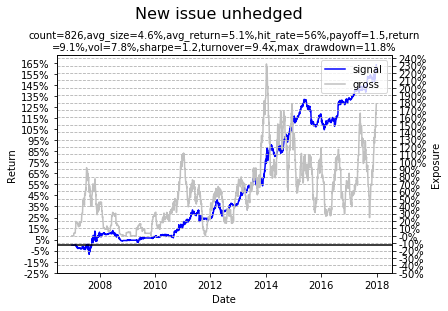

In [937]:
plot_account_curve(signal1_account_abs(signal_abs_date,Global,2,3,50,0.2),'Date','New issue unhedged',[6,4])


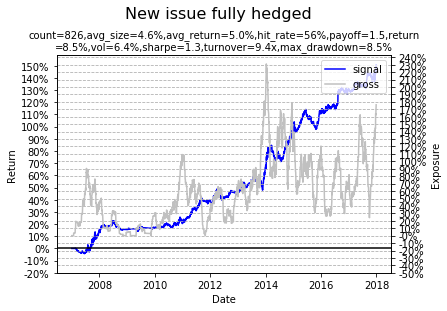

In [938]:
plot_account_curve(signal1_account_abs(signal_rel_date,Global,2,3,50,0.2),'Date','New issue fully hedged',[6,4])


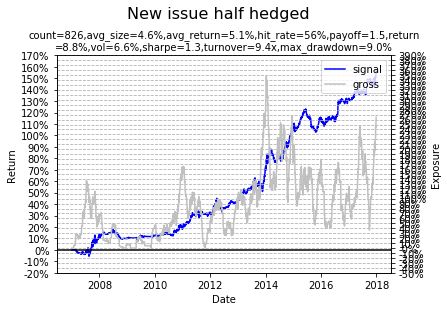

In [939]:
plot_account_curve(signal1_account_half_rel(signal_half_rel_date,Global,2,3,50,0.2),'Date','New issue half hedged',[6,4])


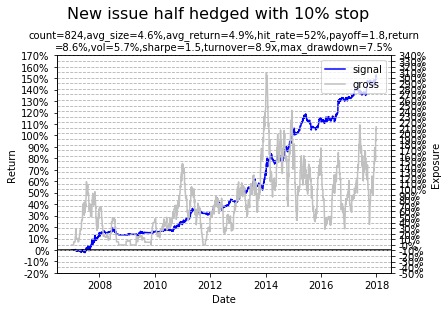

In [940]:
plot_account_curve(signal1_account_half_rel(signal_simple_stop(signal_half_rel_date,0.1),Global,2,3,50,0.2),'Date','New issue half hedged with 10% stop',[6,4])


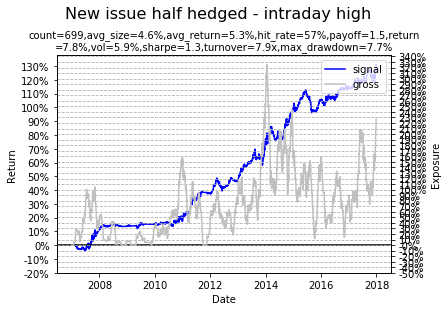

In [907]:
plot_account_curve(signal1_account_half_rel(signal_half_rel_date_intraday,Global,2,3,50,0.2),'Date','New issue half hedged - intraday high',[6,4])


In [898]:
signal_abs_Europe_date=IPO_long_date(Europe,date_Europe,price_Europe,None,abs_return_Europe,abs_return_index.loc["SX5E Index"],\
                             500,-2,-2,3,10,50,40,0.99)
signal_abs_NA_date=IPO_long_date(NA,date_NA,price_NA,None,abs_return_NA,abs_return_index.loc["SX5E Index"],\
                             500,-2,-2,3,10,50,40,0.99)
signal_abs_Asia_date=IPO_long_date(Asia,date_Asia,price_Asia,None,abs_return_Asia,abs_return_index.loc["SX5E Index"],\
                             500,-2,-2,3,10,50,40,0.99)
signal_abs_date=pd.concat([signal_abs_Europe_date,signal_abs_NA_date,signal_abs_Asia_date],axis=1)

In [933]:
signal_rel_Europe_date=IPO_long_date(Europe,date_Europe,price_Europe,None,rel_return_Europe,abs_return_index.loc["SX5E Index"],\
                             500,-2,-2,3,10,50,40,0.99)
signal_rel_NA_date=IPO_long_date(NA,date_NA,price_NA,None,rel_return_NA,abs_return_index.loc["SX5E Index"],\
                             500,-2,-2,3,10,50,40,0.99)
signal_rel_Asia_date=IPO_long_date(Asia,date_Asia,price_Asia,None,rel_return_Asia,abs_return_index.loc["SX5E Index"],\
                             500,-2,-2,3,10,50,40,0.99)
signal_rel_date=pd.concat([signal_rel_Europe_date,signal_rel_NA_date,signal_rel_Asia_date],axis=1)

In [936]:
signal_half_rel_Europe_date=IPO_long_date(Europe,date_Europe,price_Europe,None,rel_return_half_Europe,abs_return_index.loc["SX5E Index"],\
                             500,-2,-2,3,10,50,40,0.99)
signal_half_rel_NA_date=IPO_long_date(NA,date_NA,price_NA,None,rel_return_half_NA,abs_return_index.loc["SX5E Index"],\
                             500,-2,-2,3,10,50,40,0.99)
signal_half_rel_Asia_date=IPO_long_date(Asia,date_Asia,price_Asia,None,rel_return_half_Asia,abs_return_index.loc["SX5E Index"],\
                             500,-2,-2,3,10,50,40,0.99)
signal_half_rel_date=pd.concat([signal_half_rel_Europe_date,signal_half_rel_NA_date,signal_half_rel_Asia_date],axis=1)

In [906]:
signal_half_rel_Europe_date_intraday=IPO_long_date(Europe,date_Europe,price_Europe,high_Europe,rel_return_half_Europe,abs_return_index.loc["SX5E Index"],\
                             500,-2,-2,3,10,50,40,0.99)
signal_half_rel_NA_date_intraday=IPO_long_date(NA,date_NA,price_NA,high_NA,rel_return_half_NA,abs_return_index.loc["SX5E Index"],\
                             500,-2,-2,3,10,50,40,0.99)
signal_half_rel_Asia_date_intraday=IPO_long_date(Asia,date_Asia,price_Asia,high_Asia,rel_return_half_Asia,abs_return_index.loc["SX5E Index"],\
                             500,-2,-2,3,10,50,40,0.99)
signal_half_rel_date_intraday=pd.concat([signal_half_rel_Europe_date_intraday,signal_half_rel_NA_date_intraday,signal_half_rel_Asia_date_intraday],axis=1)